# Create Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emd

In [2]:
# run tests
emd.support.run_tests()

# 1: Demixing Nonstationary Coupled Oscillators

In [3]:
# generate oscillator with two frequencies
T = 10 # duration in seconds
fs = 1000 # sampling frequency in Hz
dt = 1/fs
t = np.arange(0, T, dt) # time vector
if_slow = 5 + 2*np.sin(2*np.pi*0.5*t) # frequency 1 that oscillates with 0.5 Hz around 5 Hz with amplitude 2 Hz
ip_slow = 2 * np.pi * np.cumsum(if_slow) * dt # ip_slow = 2*pi int(if_slow dt)
amp_slow = 5
ip_slow = np.mod(ip_slow, 2*np.pi) # wrap phase [0, 2*pi]
slow_sig = amp_slow * np.cos(ip_slow)

# amp_fast and if_fast are modulate by ip_slow, at peaks of ip_slow
amp_fast = 2 + 2*np.sin(ip_slow + np.pi/2)
if_fast = 25 + 0.5*np.sin(ip_slow)
ip_fast = 2 * np.pi * np.cumsum(if_fast) * dt
fast_sig = amp_fast * np.cos(ip_fast)

# combine slow and fast oscillations
sig = slow_sig + fast_sig
imfs = np.array([fast_sig, slow_sig]).T

# EMD
- Decompose signal into IMFs
- Compute the instantaneous phase, frequency, and amplitude of IMFs
- plot instantaneous frequency and amplitude of fast oscillation against phase of slow oscillation

<Figure size 921.6x691.2 with 0 Axes>

<Figure size 640x480 with 0 Axes>

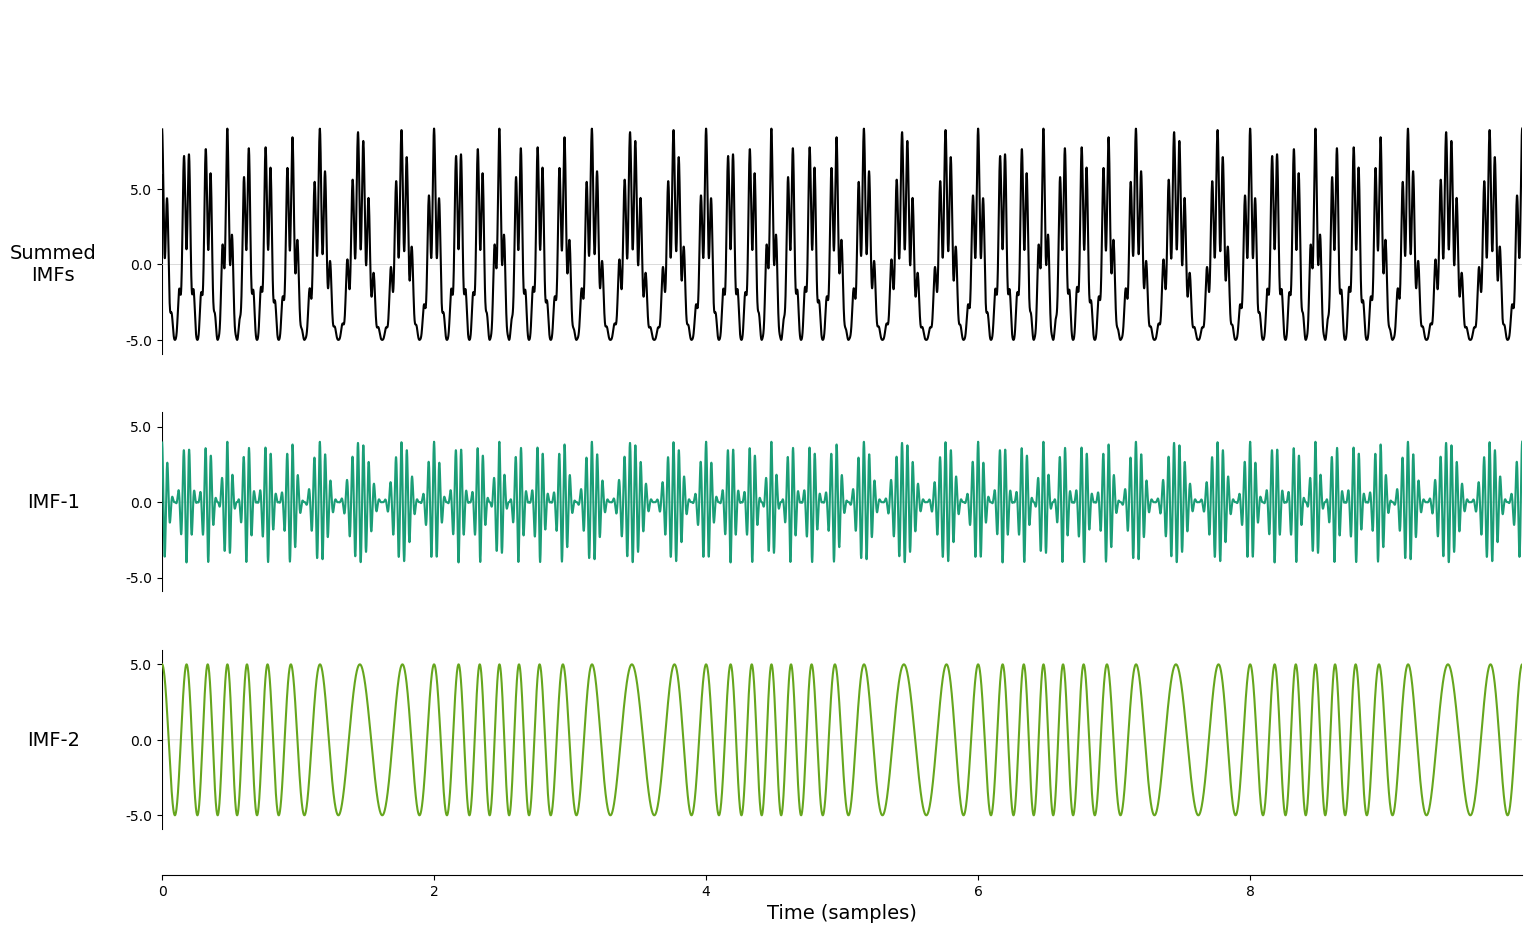

In [12]:
%matplotlib inline
plt.figure()
emd.plotting.plot_imfs(imfs, t)
plt.show()

(10000, 6)


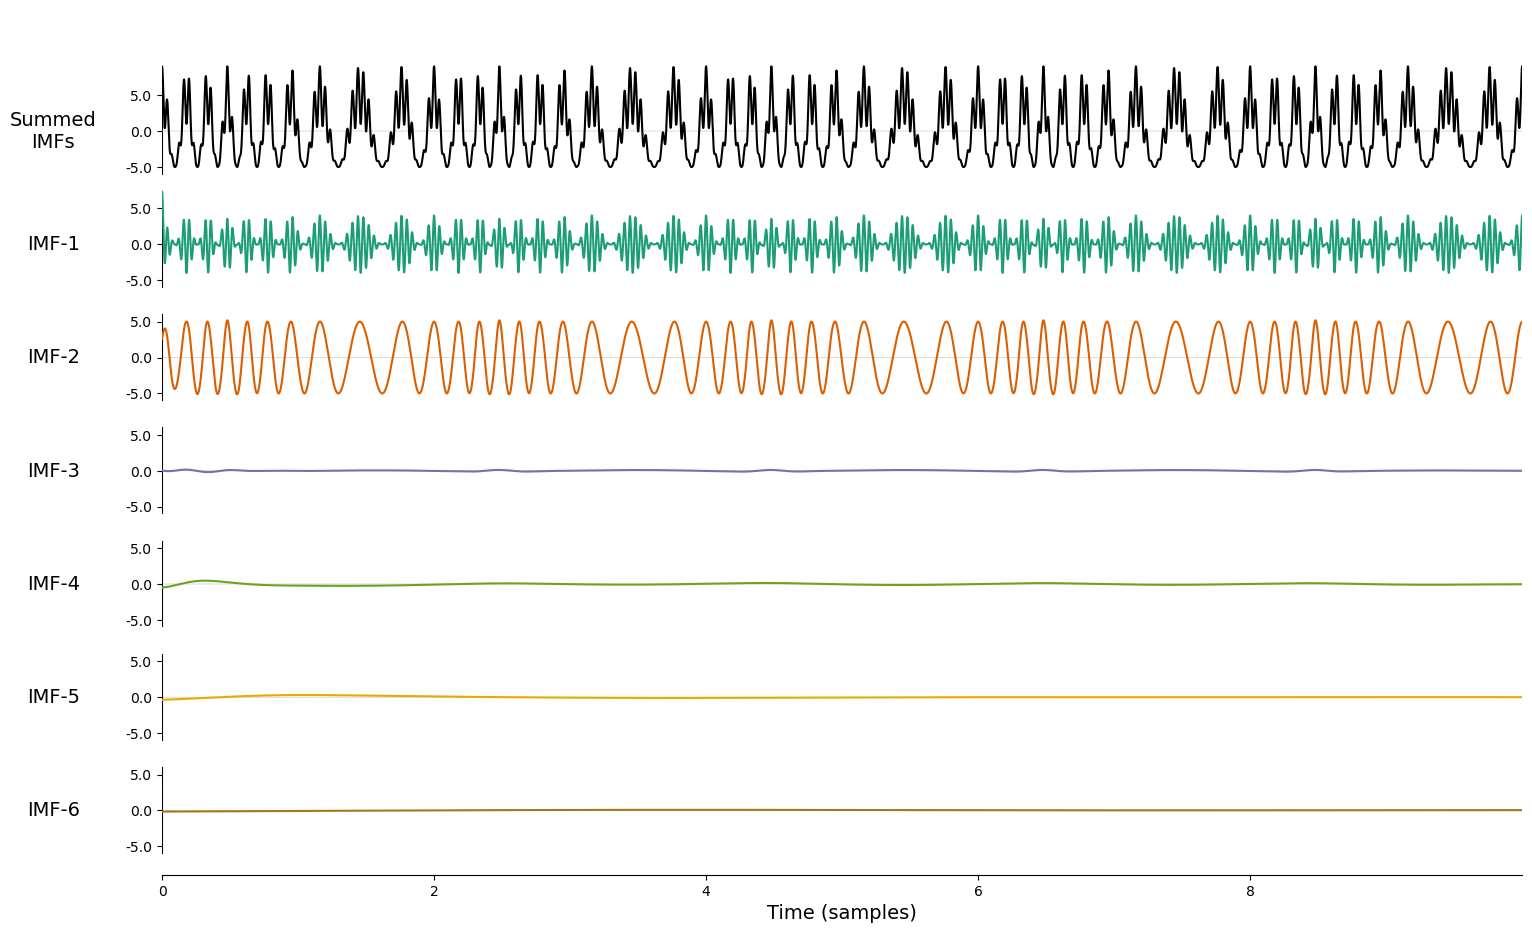

In [13]:
# get IMFs
sig_imfs = emd.sift.sift(sig)
print(sig_imfs.shape)

# plot imfs
emd.plotting.plot_imfs(sig_imfs, t)
plt.show()

(10000, 6)
(57, 10000)
(57,)


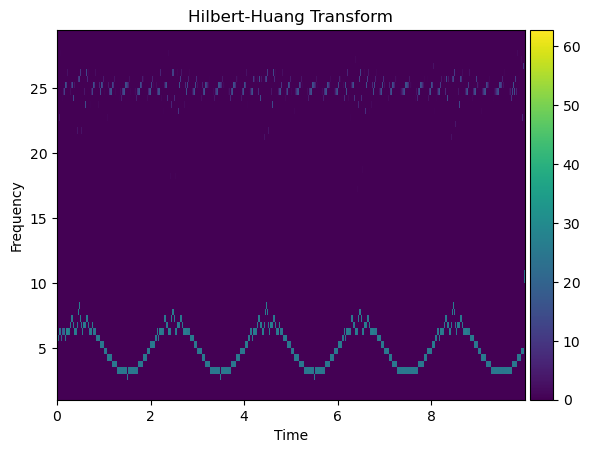

In [14]:
# get instantaneous phase, frequency, and amplitude via hilbert transform
IP, IF, IA = emd.sift.frequency_transform(sig_imfs, fs, 'hilbert')
print(IF.shape)

# get hilert-huang transform
f, hht = emd.spectra.hilberthuang(IF, IA, edges=np.arange(1, 30, 0.5), sample_rate=fs, sum_time=False)
print(hht.shape)
print(f.shape)
# plot hht
fig, ax = plt.subplots()
emd.plotting.plot_hilberthuang(hht, t, f, ax=ax, cmap='viridis')
plt.show()

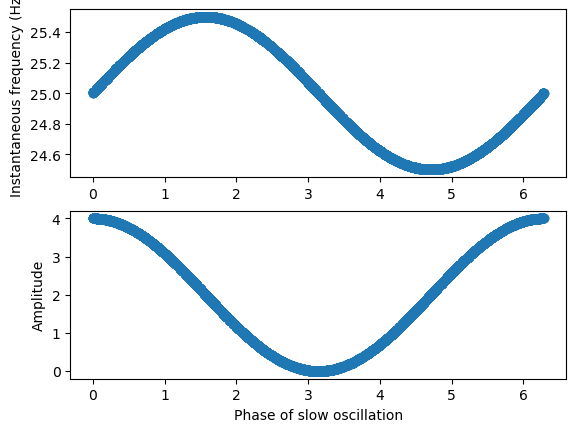

In [15]:
# plot instantaneous frequency and amplitude of fast oscillation as a function of the phase of the slow oscillation
plt.figure()
plt.subplot(2,1,1)
plt.scatter(ip_slow, if_fast)
plt.ylabel('Instantaneous frequency (Hz)')
plt.subplot(2,1,2)
plt.scatter(ip_slow, amp_fast)
plt.ylabel('Amplitude')
plt.xlabel('Phase of slow oscillation')
plt.show()

# 2. Construct Signal with Waveform Motifs

# IF Motifs
Define Instantaneous Frequency Profile Motifs And Get Corrseponding Waveforms

reproduce Fig.2 from the paper

In [213]:
import numpy as np
import matplotlib.pyplot as plt

# Define phase grid
phase_grid = np.linspace(0, 2 * np.pi, 100)

# Function to calculate IF profile for a given motif
def calculate_IF_profile(motif, phase_grid):
    if motif == "sinusoid":
        return np.zeros_like(phase_grid)  # Sinusoid IF profile is constant
    elif motif == "extrema_asymmetry":
        return 0.2 * np.sin(phase_grid)
    elif motif == "edge_asymmetry":
        return 0.2 * np.cos(phase_grid)
    elif motif == "extrema_curvature":
        return 0.2 * np.cos(2 * phase_grid)
    else:
        raise ValueError("Unknown motif type")

# Function to calculate phase profile based on IF profile
def calculate_phase_profile(IF_profile):
    return np.cumsum(IF_profile) / np.sum(IF_profile) * 2 * np.pi

# Function to calculate waveform based on phase profile
def calculate_waveform(PF_profile):
    return np.cos(PF_profile)

# Motif types and corresponding profiles
motifs = ["sinusoid", "extrema_asymmetry", "edge_asymmetry", "extrema_curvature"]
IF_profiles = [calculate_IF_profile(motif, phase_grid) for motif in motifs]
PF_profiles = [calculate_phase_profile(1+IF) for IF in IF_profiles]
WF_profiles = [calculate_waveform(PF) for PF in PF_profiles]

# Sinusoid counterparts for plotting as dashed lines
sinusoid_IF = IF_profiles[0]
sinusoid_PF = PF_profiles[0]
sinusoid_WF = WF_profiles[0]

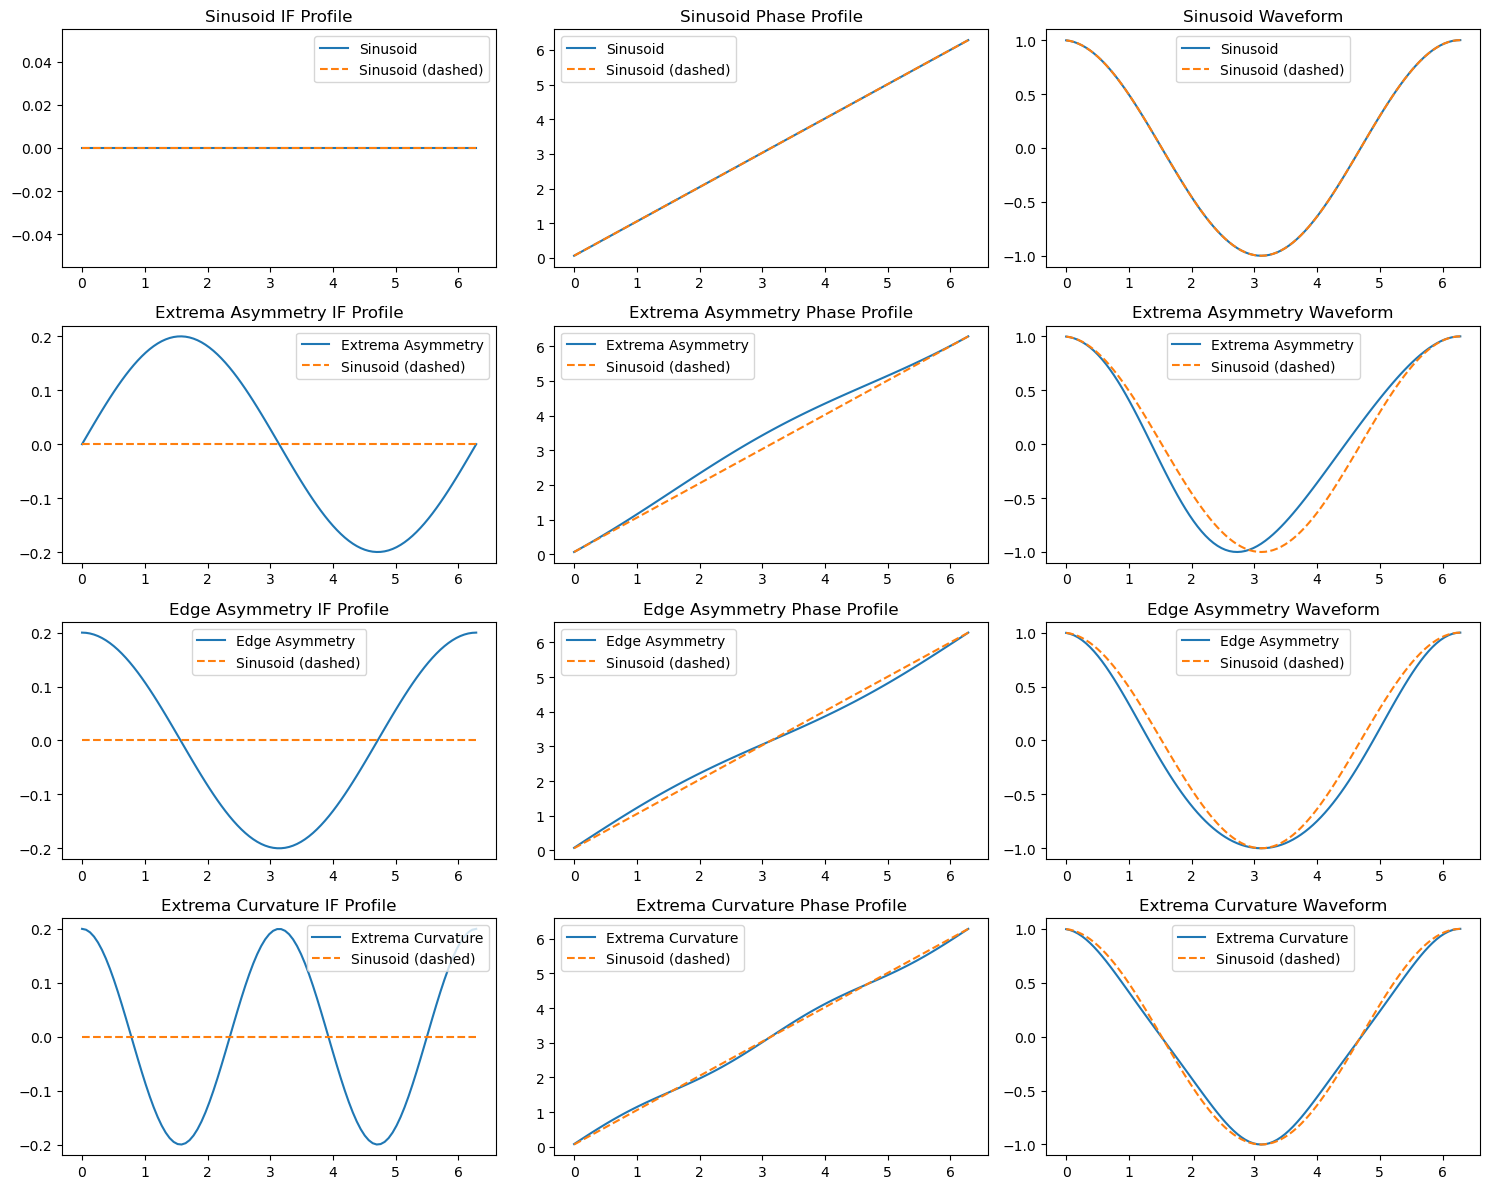

In [214]:
# Adjusting the grid dimensions and indexing issues in plot layout

fig, axes = plt.subplots(4, 3, figsize=(15, 12))  # Switching to a 4x3 layout to fit all plots

# Updated titles for each row based on motif
plot_titles = ["IF Profile", "Phase Profile", "Waveform"]
motif_titles = ["Sinusoid", "Extrema Asymmetry", "Edge Asymmetry", "Extrema Curvature"]
plot_data = [(IF_profiles, sinusoid_IF), (PF_profiles, sinusoid_PF), (WF_profiles, sinusoid_WF)]

for i, motif in enumerate(motif_titles):
    for j, (profile, sinusoid_profile) in enumerate(plot_data):
        axes[i, j].plot(phase_grid, profile[i], label=motif)
        axes[i, j].plot(phase_grid, sinusoid_profile, linestyle="--", label="Sinusoid (dashed)")
        axes[i, j].set_title(f"{motif} {plot_titles[j]}")
        axes[i, j].legend()

plt.tight_layout()
plt.show()

# Gaussian Clusters in 3D principal axes states
the IF profiles above, other than sinusoid, are what we use as our 3 principal axes

In [215]:
import numpy as np
import pandas as pd

# Parameters
n_pcs = 3        # Dimensionality of the space (3D)
n_clusters = 3   # Number of clusters
samples_per_cluster = 400
n_cycles = n_clusters * samples_per_cluster

# Define mean vectors and standard deviations for each cluster in 3D
cluster_means = [
    [1.0, 0.5, -0.5],
    [2.0, -1.5, 1.0],
    [-1.5, 1.8, -0.8]
]

cluster_stds = [
    [0.3, 0.2, 0.3],
    [0.5, 0.3, 0.2],
    [0.2, 0.4, 0.3]
]

# Generate samples for each cluster
clusters = [
    np.random.multivariate_normal(mean, np.diag(np.square(stds)), samples_per_cluster)
    for mean, stds in zip(cluster_means, cluster_stds)
]

# Combine all clusters into a single array and create labels
pc_components = np.array(IF_profiles[1:])
pc_scores = np.vstack(clusters)
cluster_labels = np.concatenate([[i] * samples_per_cluster for i in range(n_clusters)])

# Create a DataFrame with sample points and cluster labels
df = pd.DataFrame(pc_scores, columns=[f'PC{i+1}' for i in range(n_pcs)])
df['Cluster'] = cluster_labels

# Display the DataFrame
print(df.head())


        PC1       PC2       PC3  Cluster
0  0.987780  0.238593 -0.484835        0
1  1.723413  0.017092 -0.402781        0
2  1.648919  0.323592 -0.293592        0
3  1.064351  0.645690 -0.616959        0
4  1.140510  0.420498 -0.266291        0


In [256]:
%matplotlib inline
# map cluster mean to phase grid

sinusoid_IF = 12 * np.ones_like(phase_grid)
cluster_IF_motifs = 2 * np.array(cluster_means) @ pc_components + 12
cluster_IP_motifs = np.array([calculate_phase_profile(if_profile) for if_profile in cluster_IF_motifs])
cluster_WF_profiles = [calculate_waveform(PF) for PF in PF_profiles]

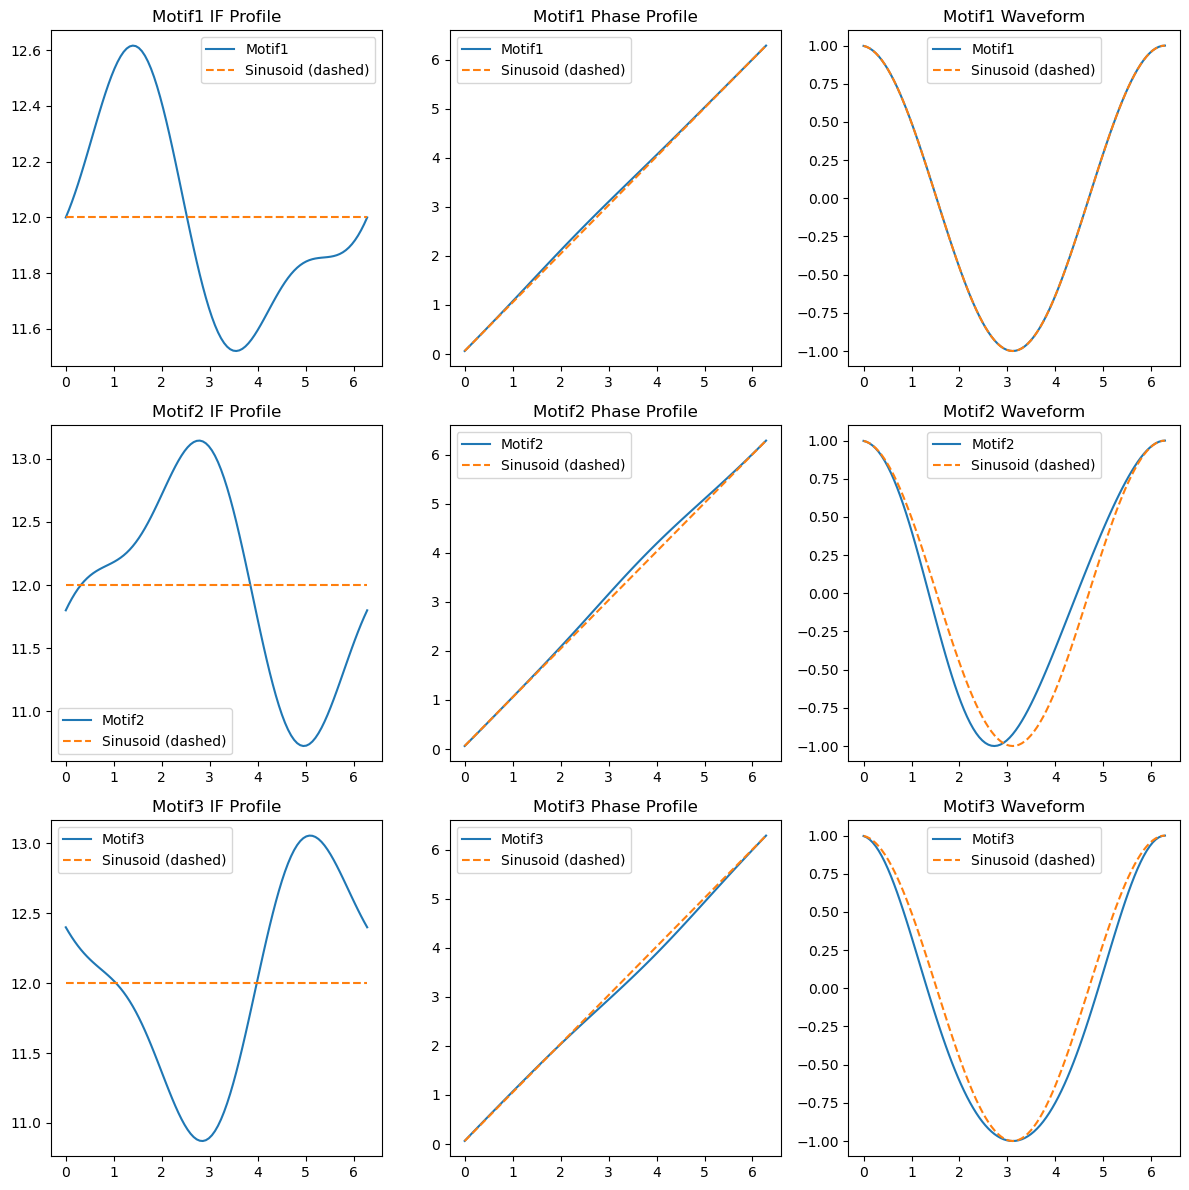

In [257]:
# Adjusting the grid dimensions and indexing issues in plot layout

fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # Switching to a 4x3 layout to fit all plots

# Updated titles for each row based on motif
plot_titles = ["IF Profile", "Phase Profile", "Waveform"]
motif_titles = ["Motif1", "Motif2", "Motif3"]
plot_data = [(cluster_IF_motifs, sinusoid_IF), (cluster_IP_motifs, sinusoid_PF), (cluster_WF_profiles, sinusoid_WF)]

for i, motif in enumerate(motif_titles):
    for j, (profile, sinusoid_profile) in enumerate(plot_data):
        axes[i, j].plot(phase_grid, profile[i], label=motif)
        axes[i, j].plot(phase_grid, sinusoid_profile, linestyle="--", label="Sinusoid (dashed)")
        axes[i, j].set_title(f"{motif} {plot_titles[j]}")
        axes[i, j].legend()

plt.tight_layout()
plt.show()

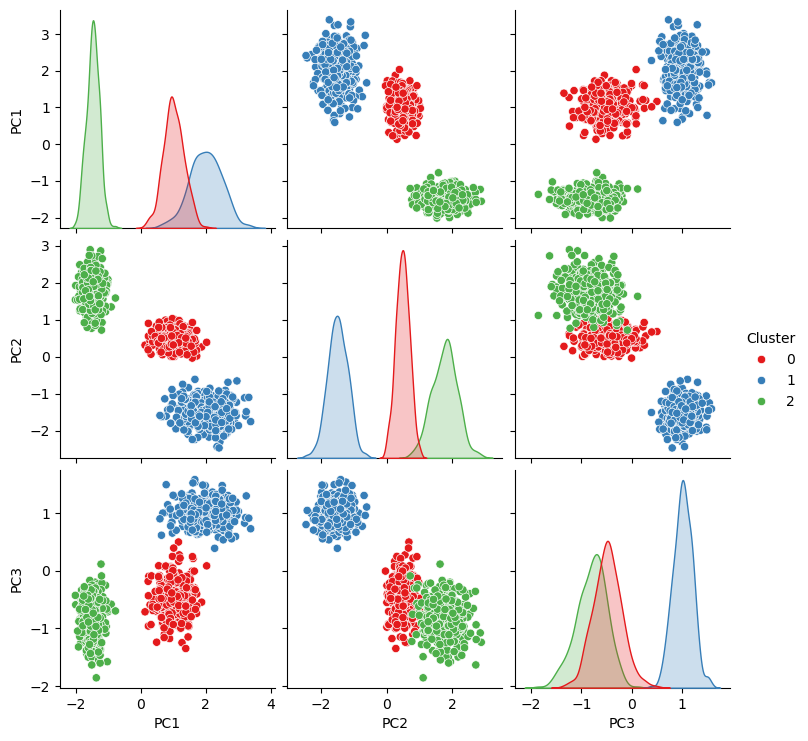

In [224]:
import seaborn as sns

# Plot the pairplot with Seaborn
sns.pairplot(df, hue="Cluster", palette="Set1", diag_kind="kde")
plt.show()

In [258]:
IF_design_matrix = 2*(pc_scores @ pc_components) + 12
print(IF_design_matrix.shape) # (1200, 100) = (n_cycles, n_phase_bins)

(1200, 100)


# Distort Phase Alignment

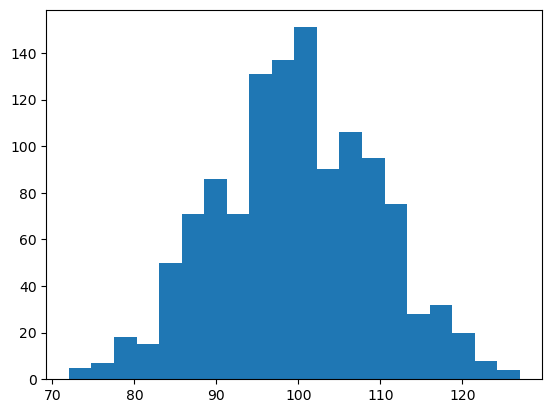

In [259]:
%matplotlib inline
# define a gaussian distribution with mean one and std 0.3
mean = 1
std = 0.1
distorted_nsamples = np.round(100 * np.random.normal(loc=mean, scale=std, size=(n_cycles))).astype(int)
# clip values to be within [50, 150]
distorted_nsamples = np.clip(distorted_nsamples, 50, 150)
plt.hist(distorted_nsamples, bins=20)
plt.show()

In [227]:
# 12 Hz oscillation, with fs=1200 has 100 samples per cycle

fs_ = 1200
n_phase_bins = 100
# resample signal into target distorted_nsamples
IF_design_matrix_resampled = np.ndarray(n_cycles, dtype=object)
from scipy.signal import resample
for i in range(n_cycles):
    IF_design_matrix_resampled[i] = resample(IF_design_matrix[i], distorted_nsamples[i])

In [260]:
import numpy as np

# Assuming IF_design_matrix_resampled is a list of arrays with different lengths
n_cycles = len(IF_design_matrix_resampled)
max_sample = max(len(x) for x in IF_design_matrix_resampled)

# Pad each array with NaN to the maximum sample length
IF_design_matrix_resampled_padded = np.array([
    np.pad(x, (0, max_sample - len(x)), mode='constant', constant_values=np.nan) 
    for x in IF_design_matrix_resampled
])

# This will have shape (n_cycles, max_sample) and be padded with NaN values
print(IF_design_matrix_resampled_padded.shape)

(1200, 131)


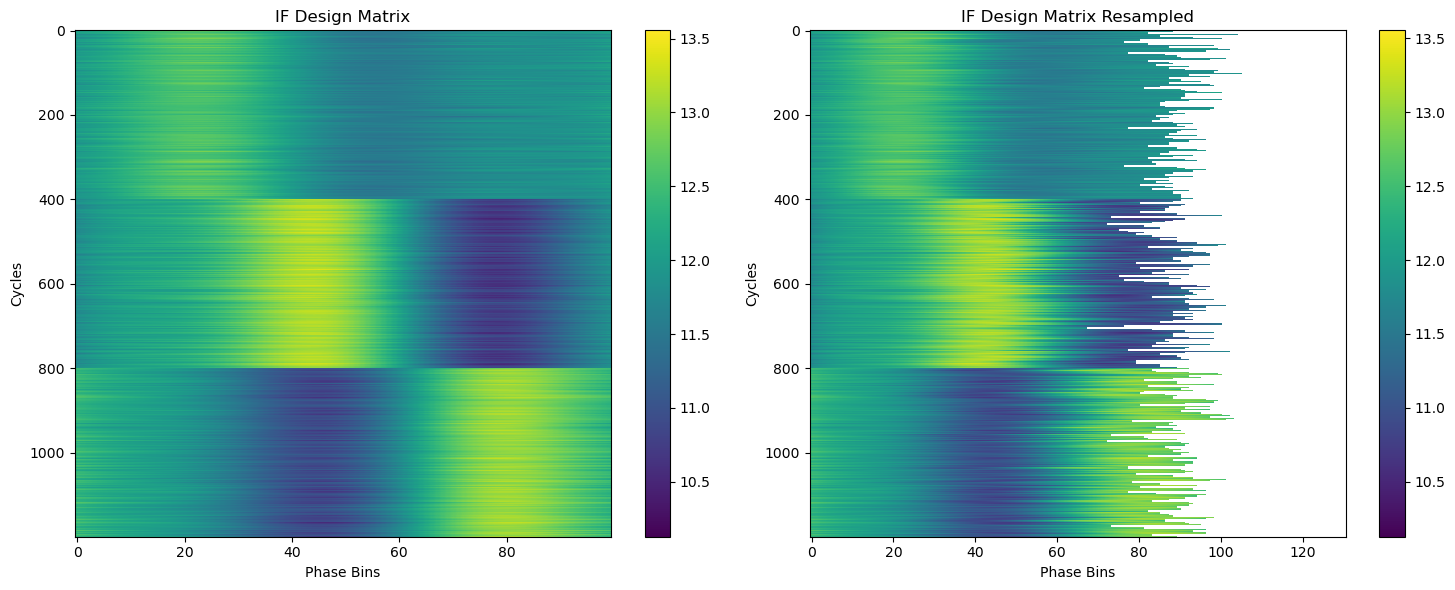

In [229]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot IF_design_matrix
im1 = axes[0].imshow(IF_design_matrix, aspect='auto')
axes[0].set_title('IF Design Matrix')
axes[0].set_xlabel('Phase Bins')
axes[0].set_ylabel('Cycles')
fig.colorbar(im1, ax=axes[0])  # Attach colorbar to the first subplot

# Plot IF_design_matrix_resampled_padded
im2 = axes[1].imshow(IF_design_matrix_resampled_padded, aspect='auto')
axes[1].set_title('IF Design Matrix Resampled')
axes[1].set_xlabel('Phase Bins')
axes[1].set_ylabel('Cycles')
fig.colorbar(im2, ax=axes[1])  # Attach colorbar to the second subplot

plt.tight_layout()
plt.show()

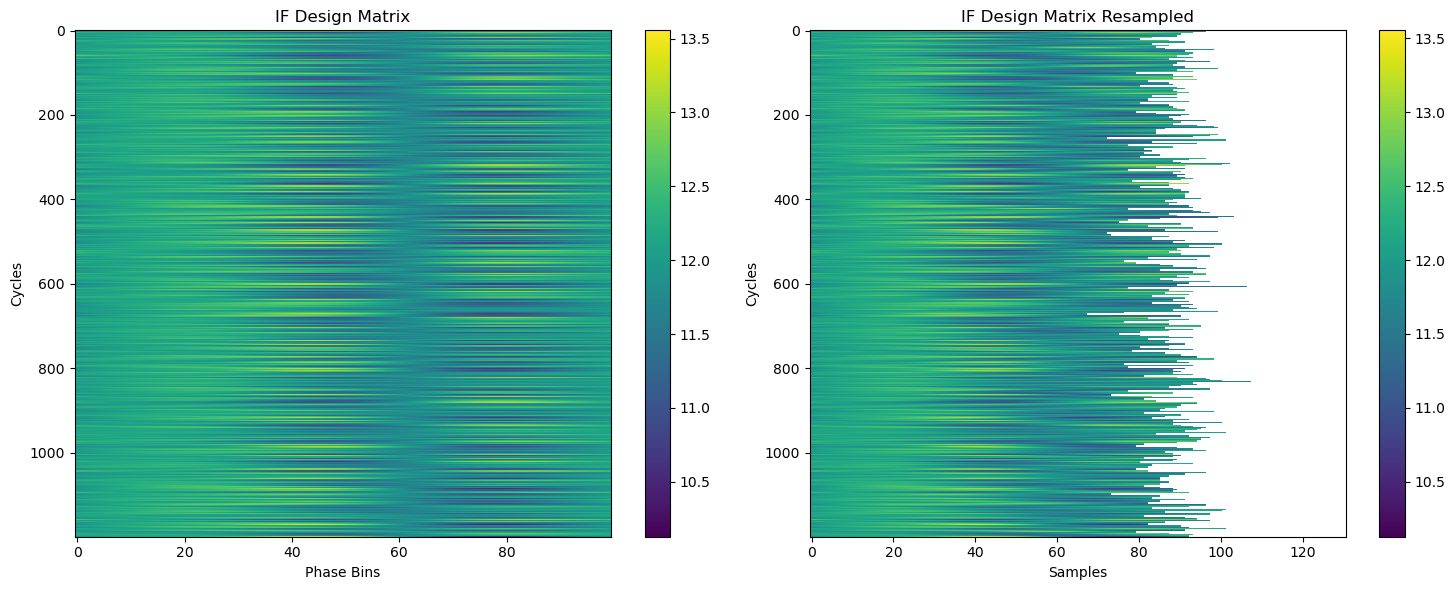

In [261]:
# sort by nsample
sorted_indices = np.argsort(distorted_nsamples)
IF_design_matrix_resampled_padded_sorted = IF_design_matrix_resampled_padded[sorted_indices]
distorted_nsamples_sorted = distorted_nsamples[sorted_indices]
IF_design_matrix_sorted = IF_design_matrix[sorted_indices]

# plot sorted
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot IF_design_matrix
im1 = axes[0].imshow(IF_design_matrix_sorted, aspect='auto')
axes[0].set_title('IF Design Matrix')
axes[0].set_xlabel('Phase Bins')
axes[0].set_ylabel('Cycles')
fig.colorbar(im1, ax=axes[0])  # Attach colorbar to the first subplot

# Plot IF_design_matrix_resampled_padded
im2 = axes[1].imshow(IF_design_matrix_resampled_padded_sorted, aspect='auto')
axes[1].set_title('IF Design Matrix Resampled')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Cycles')
fig.colorbar(im2, ax=axes[1])  # Attach colorbar to the second subplot

plt.tight_layout()
plt.show()

# Concatenate cycles into signal
concatenate cycles through stochastic linear combination of princial components

In [262]:
# concatenate
IF_all_cycles_mat = IF_design_matrix_resampled # (shuffle?)
IP_all_cycles_mat = np.array([calculate_phase_profile(if_prof_) for if_prof_ in IF_all_cycles_mat], dtype=object)

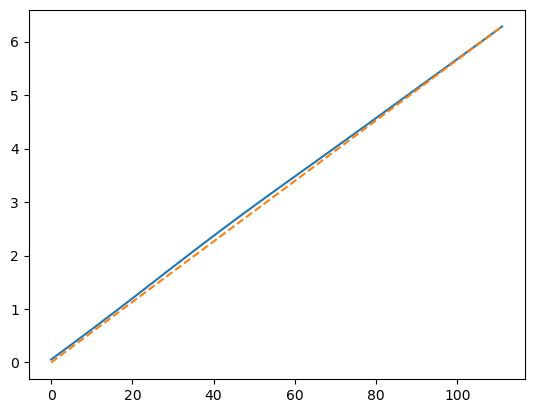

In [263]:
%matplotlib inline
plt.plot(IP_all_cycles_mat[0])
plt.plot(np.linspace(0, 2*np.pi, len(IP_all_cycles_mat[0])), '--')

In [264]:
IP_IMF_main = np.concatenate(IP_all_cycles_mat)
dt_  = 1/fs_
time_vect = np.arange(len(IP_IMF_main)) * dt_

# get signal
amp_IMF_main = 5
sig_IMF_main = amp_IMF_main * np.cos(IP_IMF_main)

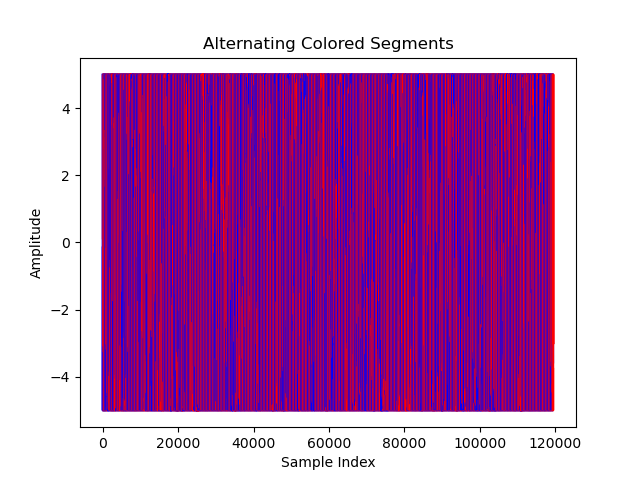

In [265]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt

# Define the colors to alternate
colors = ['b', 'r']

# Plot each segment with alternating colors
start = 0
for i, length in enumerate(distorted_nsamples):
    end = start + length
    plt.plot(np.arange(start, end), sig_IMF_main[start:end], color=colors[i % 2])
    start = end

plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.title("Alternating Colored Segments")
plt.show()

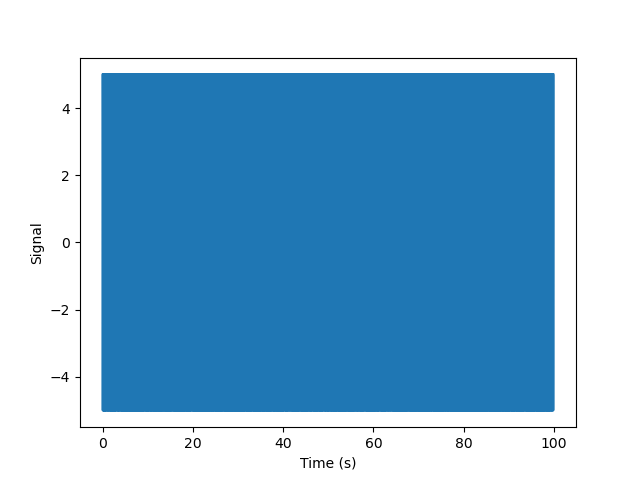

In [ ]:
%matplotlib widget
# plot
plt.figure()
plt.plot(time_vect, sig_IMF_main)
plt.xlabel('Time (s)')
plt.ylabel('Signal')
plt.show()

# Apply PCA